<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/docs/docs/colab-notebook/chronos/chronos_autots_nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


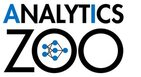
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Analytics Zoo**

You can install the latest pre-release version with chronos support using `pip install --pre --upgrade analytics-zoo[automl]`. 

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[automl]
exit() # restart the runtime to refresh installed pkg

### **Step 0: Download & prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [ ]:
# download the dataset
!wget https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv

In [ ]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
df = pd.read_csv("nyc_taxi.csv", parse_dates=["timestamp"])

## **Time series forecasting using Chronos Forecaster**
### Forecaster Step1. Data transformation and feature engineering using Chronos TSDataset 
[TSDataset](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [ ]:
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

Initialize train, valid and test tsdataset from raw pandas dataframe.

In [ ]:
tsdata_train, tsdata_valid, tsdata_test = TSDataset.from_pandas(df, dt_col="timestamp", target_col="value",
                                                                with_split=True, val_ratio=0.1, test_ratio=0.1)

Preprocess the datasets. Here we perform:
- deduplicate: remove those identical data records
- impute: fill the missing values
- gen_dt_feature: generate feature from datetime (e.g. month, day...)
- scale: scale each feature to standard distribution.
- roll: sample the data with sliding window.

For forecasting task, we will look back 3 hours' historical data (6 records) and predict the value of next 30 miniutes (1 records).

We perform the same transformation processes on train, valid and test set.

In [ ]:
lookback, horizon = 6, 1

scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=lookback, horizon=horizon)

### Forecaster Step 2: Time series forecasting using Chronos Forecaster
After preprocessing the datasets. We can use [Chronos Forecaster](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html) to handle the forecasting tasks.

In [ ]:
# set random seeds to help reproduce the same result
import torch, random, numpy
from zoo.chronos.model.forecast.tcn_forecaster import TCNForecaster
torch.manual_seed(0)
numpy.random.seed(0)
random.seed(0)

Transform TSDataset to sampled numpy ndarray and feed them to forecaster.

In [ ]:
x, y = tsdata_train.to_numpy() 
x_val, y_val = tsdata_valid.to_numpy() 
# x.shape = (num of sample, lookback, num of input feature)
# y.shape = (num of sample, horizon, num of output feature)

forecaster = TCNForecaster(past_seq_len=lookback,  # number of steps to look back
                           future_seq_len=horizon,  # number of steps to predict
                           input_feature_num=x.shape[-1],  # number of feature to use
                           output_feature_num=y.shape[-1])  # number of feature to predict
res = forecaster.fit(x, y, validation_data=(x_val, y_val), epochs=3)

### Forecaster Step 3: Further deployment with fitted forecaster
Use fitted forecaster to predict test data and plot the result

In [ ]:
x_test, y_test = tsdata_test.to_numpy()
pred = forecaster.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.plot(pred_unscale[:,:,0])
plt.plot(groundtruth_unscale[:,:,0])
plt.legend(["prediction", "ground truth"])

Save & restore the forecaster.

In [ ]:
forecaster.save("nyc_taxi.fxt")
forecaster.restore("nyc_taxi.fxt")